In [33]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# import cnn_utils as utils
# from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [34]:
sp.__version__

'1.4.1'

In [35]:
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
from tensorflow.keras.applications import vgg16 as vgg
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils 
import np_utils

In [36]:
# import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [38]:
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [39]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [41]:

Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

In [42]:
import cv2


X_train = np.array([cv2.resize(x, (48, 48)) for x in X_train])
X_val = np.array([cv2.resize(x, (48, 48)) for x in X_val])
X_test = np.array([cv2.resize(x, (48, 48)) for x in X_test])


# height = 256
# width  = 256
# ...
# img_array = cv2.imread((train_dir+str(img_name)+".png"))
# new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE),3)
# img = ...
# img = np.array(Image.fromarray(img).resize(height, width), PIL.Image.BILINEAR).astype(np.double)


### Prepare the Model
Load VGG16 without the top classification layer

Prepare a custom classifier

Stack both models on top of each other

In [43]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

In [44]:
last = base_model.get_layer('block3_pool').output

In [45]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

In [46]:
for layer in base_model.layers:
     layer.trainable = False

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [54]:

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

### Data Augmentation
To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using keras utilities

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [56]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [57]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

Train the Model

In [58]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/20
1328/1328 [==============================] - 724s 545ms/step - loss: 1.6859 - accuracy: 0.4072 - val_loss: 1.2037 - val_accuracy: 0.5881
Epoch 2/20
1328/1328 [==============================] - 727s 547ms/step - loss: 1.2738 - accuracy: 0.5609 - val_loss: 1.0345 - val_accuracy: 0.6436
Epoch 3/20
1328/1328 [==============================] - 724s 545ms/step - loss: 1.1339 - accuracy: 0.6076 - val_loss: 0.9511 - val_accuracy: 0.6721
Epoch 4/20
1328/1328 [==============================] - 723s 545ms/step - loss: 1.0478 - accuracy: 0.6371 - val_loss: 0.8943 - val_accuracy: 0.6875
Epoch 5/20
1328/1328 [==============================] - 724s 545ms/step - loss: 0.9944 - accuracy: 0.6569 - val_loss: 0.8569 - val_accuracy: 0.7002
Epoch 6/20
1328/1328 [==============================] - 723s 544ms/step - loss: 0.9514 - accuracy: 0.6687 - val_loss: 0.8324 - val_accuracy: 0.7121
Epoch 7/20
1328/1328 [==============================] - 724s 545ms/step - loss: 0.9182 - accuracy: 0.6823 - val_

Analyze Model Performance

[0.4071771800518036, 0.5608693361282349, 0.6075868606567383, 0.6371150016784668, 0.6568946242332458, 0.668738842010498, 0.6823490858078003, 0.6916502118110657, 0.6997033357620239, 0.7057313919067383, 0.7163511514663696, 0.7198361158370972, 0.7250400185585022, 0.7308090925216675, 0.734294056892395, 0.7362013459205627, 0.7413817644119263, 0.7450079917907715, 0.745596706867218, 0.75176602602005]


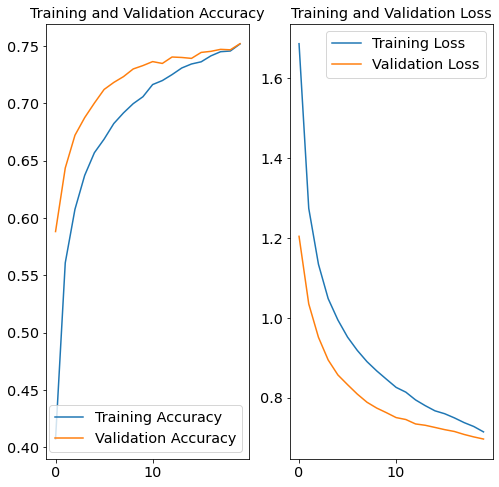

In [64]:
acc = history.history['accuracy']
print(acc)
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
predictions = model.predict(X_test/255.)

In [66]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [69]:
print(test_labels)
print(predictions)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 3, 4, 1, 7, 5, 4, 6, 1, 9, 3, 

In [70]:
catagories = {'dog': 0,'automobile': 1,'bird': 2,'cat': 3,'deer': 4,'airplane': 5,'frog': 6,'horse': 7,'ship': 8,'truck': 9}
reverse_catagory = {n:i for i,n in catagories.items()}
print(reverse_catagory)

{0: 'dog', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'airplane', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [71]:
test_dataset = [reverse_catagory[name] for name in test_labels]
print(test_dataset[:5])

['cat', 'ship', 'ship', 'dog', 'frog']


In [72]:
prediction_dataset = [reverse_catagory[name] for name in predictions]
print(prediction_dataset[:5])

['cat', 'ship', 'ship', 'ship', 'frog']


In [74]:
final_dataset = pd.DataFrame({"Actual":test_dataset,"Prediction":prediction_dataset})
final_dataset.head()

,Actual,Prediction
0,cat,cat
1,ship,ship
2,ship,ship
3,dog,ship
4,frog,frog
